In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.ticker as ticker
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Input, Embedding, Dense, Conv1D, Flatten, Concatenate, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## Load Data

In [4]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [5]:
print(f"Training dataset size: {X_train.shape, y_train.shape}")
print(f"Test dataset size: {X_test.shape, y_test.shape}")

Training dataset size: ((1482243, 97), (1482243,))
Test dataset size: ((635247, 97), (635247,))


In [6]:
X_train = X_train.astype({col: 'float64' for col in X_train.select_dtypes(include=['boolean']).columns})
X_test = X_test.astype({col: 'float64' for col in X_test.select_dtypes(include=['boolean']).columns})

## Handle Class Imbalance with SMOTE

In [7]:
# handle class imbalance for training set
smote = SMOTE(random_state=4266)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled dataset size: {X_resampled.shape, y_resampled.shape}")

Resampled dataset size: ((11138920, 97), (11138920,))


(array([1713680.,  856840.,  856840.,  856840.,  856840., 1713680.,
         856840.,  856840.,  856840., 1713680.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

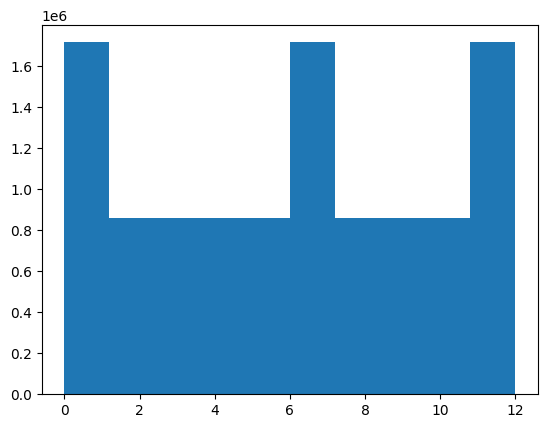

In [8]:
plt.hist(y_resampled)

In [9]:
# combine for aggregation
y_train_df = pd.DataFrame(y_resampled, columns=['attack_label'])
combined_df = pd.concat([X_resampled, y_train_df], axis=1)
# combine for aggregation
# y_train_df = pd.DataFrame(y_train, columns=['attack_label'])
# combined_df = pd.concat([X_train, y_train_df], axis=1)

In [10]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11138920 entries, 0 to 11138919
Data columns (total 98 columns):
 #   Column                                                                                                Dtype  
---  ------                                                                                                -----  
 0   frame.time                                                                                            int64  
 1   ip.src_host                                                                                           float64
 2   ip.dst_host                                                                                           float64
 3   arp.dst.proto_ipv4                                                                                    float64
 4   arp.src.proto_ipv4                                                                                    float64
 5   icmp.seq_le                                                                

## Group by time buckets & destination ip + aggregation

In [11]:
def agg_cols(df):
    agg_dict = {}
    cols = df.columns.drop(['time_buckets','ip.dst_host'])

    for col in cols:
        if col == 'attack_label':
            agg_dict[col] = lambda x: handle_mode(x)
        else:
            agg_dict[col] = 'mean'  # Use mean for other columns

    return agg_dict

def handle_mode(x):
    modes = x.mode()
    if len(modes) == 1:
        return modes[0]  
    elif len(modes) > 1:
        return random.choice(modes)  
    else:
        return x.iloc[0]  # if mode is empty


In [12]:
# discretise into 5s intervals
combined_df['time_buckets'] = pd.cut(combined_df['frame.time'], bins=range(int(combined_df['frame.time'].min()), int(combined_df['frame.time'].max()) + 5, 5))
combined_df.drop('frame.time', axis=1, inplace=True)

In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11138920 entries, 0 to 11138919
Data columns (total 98 columns):
 #   Column                                                                                                Dtype   
---  ------                                                                                                -----   
 0   ip.src_host                                                                                           float64 
 1   ip.dst_host                                                                                           float64 
 2   arp.dst.proto_ipv4                                                                                    float64 
 3   arp.src.proto_ipv4                                                                                    float64 
 4   icmp.seq_le                                                                                           float64 
 5   http.content_length                                                 

In [14]:
agg_dict = agg_cols(combined_df)
agg_df = combined_df.groupby(['ip.dst_host','time_buckets'], observed=True).agg(agg_dict)
agg_df.head()

ip.src_host  arp.dst.proto_ipv4  \
ip.dst_host time_buckets                                                
-1.049738   (1609500955, 1609500960]     1.344285           -0.035181   
            (1609501185, 1609501190]     1.344285           -0.035181   
-1.015124   (1609500955, 1609500960]     1.349247           -0.035181   
-1.013408   (1609500955, 1609500960]     1.349493           -0.035181   
-1.004668   (1609500955, 1609500960]     1.350746           -0.035181   

                                      arp.src.proto_ipv4  icmp.seq_le  \
ip.dst_host time_buckets                                                
-1.049738   (1609500955, 1609500960]           -0.035059    -0.234128   
            (1609501185, 1609501190]           -0.035059    -0.234128   
-1.015124   (1609500955, 1609500960]           -0.035059    -0.234128   
-1.013408   (1609500955, 1609500960]           -0.035059    -0.234128   
-1.004668   (1609500955, 1609500960]           -0.035059    -0.234128   

                                      http.content_length  http.response  \
ip.dst_host time_buckets                                                   
-1.049738   (1609500955, 1609500960]            -0.074736      -0.199195   
            (1609501185, 1609501190]            -0.074736      -0.199195   
-1.015124   (1609500955, 1609500960]            -0.074736      -0.199195   
-1.013408   (1609500955, 1609500960]            -0.074736      -0.199195   
-1.004668   (1609500955, 1609500960]            -0.074736      -0.199195   

                                       tcp.ack  tcp.ack_raw  tcp.checksum  \
ip.dst_host time_buckets                                                    
-1.049738   (1609500955, 1609500960] -0.183625     0.127642     -0.009060   
            (1609501185, 1609501190] -0.183621     0.287607     -1.470676   
-1.015124   (1609500955, 1609500960] -0.183622     0.262683     -0.416363   
-1.013408   (1609500955, 1609500960] -0.183628     0.261446      0.318516   
-1.004668   (1609500955, 1609500960] -0.183628     0.255153      0.314995   

                                      tcp.connection.fin  ...  raspbian  \
ip.dst_host time_buckets                                  ...             
-1.049738   (1609500955, 1609500960]                 0.0  ...       0.0   
            (1609501185, 1609501190]                 0.0  ...       0.0   
-1.015124   (1609500955, 1609500960]                 0.0  ...       0.0   
-1.013408   (1609500955, 1609500960]                 0.0  ...       0.0   
-1.004668   (1609500955, 1609500960]                 0.0  ...       0.0   

                                      requested  server  service  the  this  \
ip.dst_host time_buckets                                                      
-1.049738   (1609500955, 1609500960]        0.0     0.0      0.0  0.0   0.0   
            (1609501185, 1609501190]        0.0     0.0      0.0  0.0   0.0   
-1.015124   (1609500955, 1609500960]        0.0     0.0      0.0  0.0   0.0   
-1.013408   (1609500955, 1609500960]        0.0     0.0      0.0  0.0   0.0   
-1.004668   (1609500955, 1609500960]        0.0     0.0      0.0  0.0   0.0   

                                      title  url  was  attack_label  
ip.dst_host time_buckets                                             
-1.049738   (1609500955, 1609500960]    0.0  0.0  0.0             1  
            (1609501185, 1609501190]    0.0  0.0  0.0             1  
-1.015124   (1609500955, 1609500960]    0.0  0.0  0.0             1  
-1.013408   (1609500955, 1609500960]    0.0  0.0  0.0             1  
-1.004668   (1609500955, 1609500960]    0.0  0.0  0.0             1  

[5 rows x 96 columns]

In [15]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4703530 entries, (-1.0497381934852472, Interval(1609500955, 1609500960, closed='right')) to (6.21906652717548, Interval(1609529050, 1609529055, closed='right'))
Data columns (total 96 columns):
 #   Column                                                                                                Dtype  
---  ------                                                                                                -----  
 0   ip.src_host                                                                                           float64
 1   arp.dst.proto_ipv4                                                                                    float64
 2   arp.src.proto_ipv4                                                                                    float64
 3   icmp.seq_le                                                                                           float64
 4   http.content_length                                          

In [16]:
X_train = np.array(agg_df.drop('attack_label', axis=1))
y_train = np.array(agg_df['attack_label'])

In [17]:
X_test.drop(['frame.time', 'ip.dst_host'], axis=1, inplace=True)

In [18]:
print(X_train.shape) 
print(X_test.shape)  

(4703530, 95)
(635247, 95)


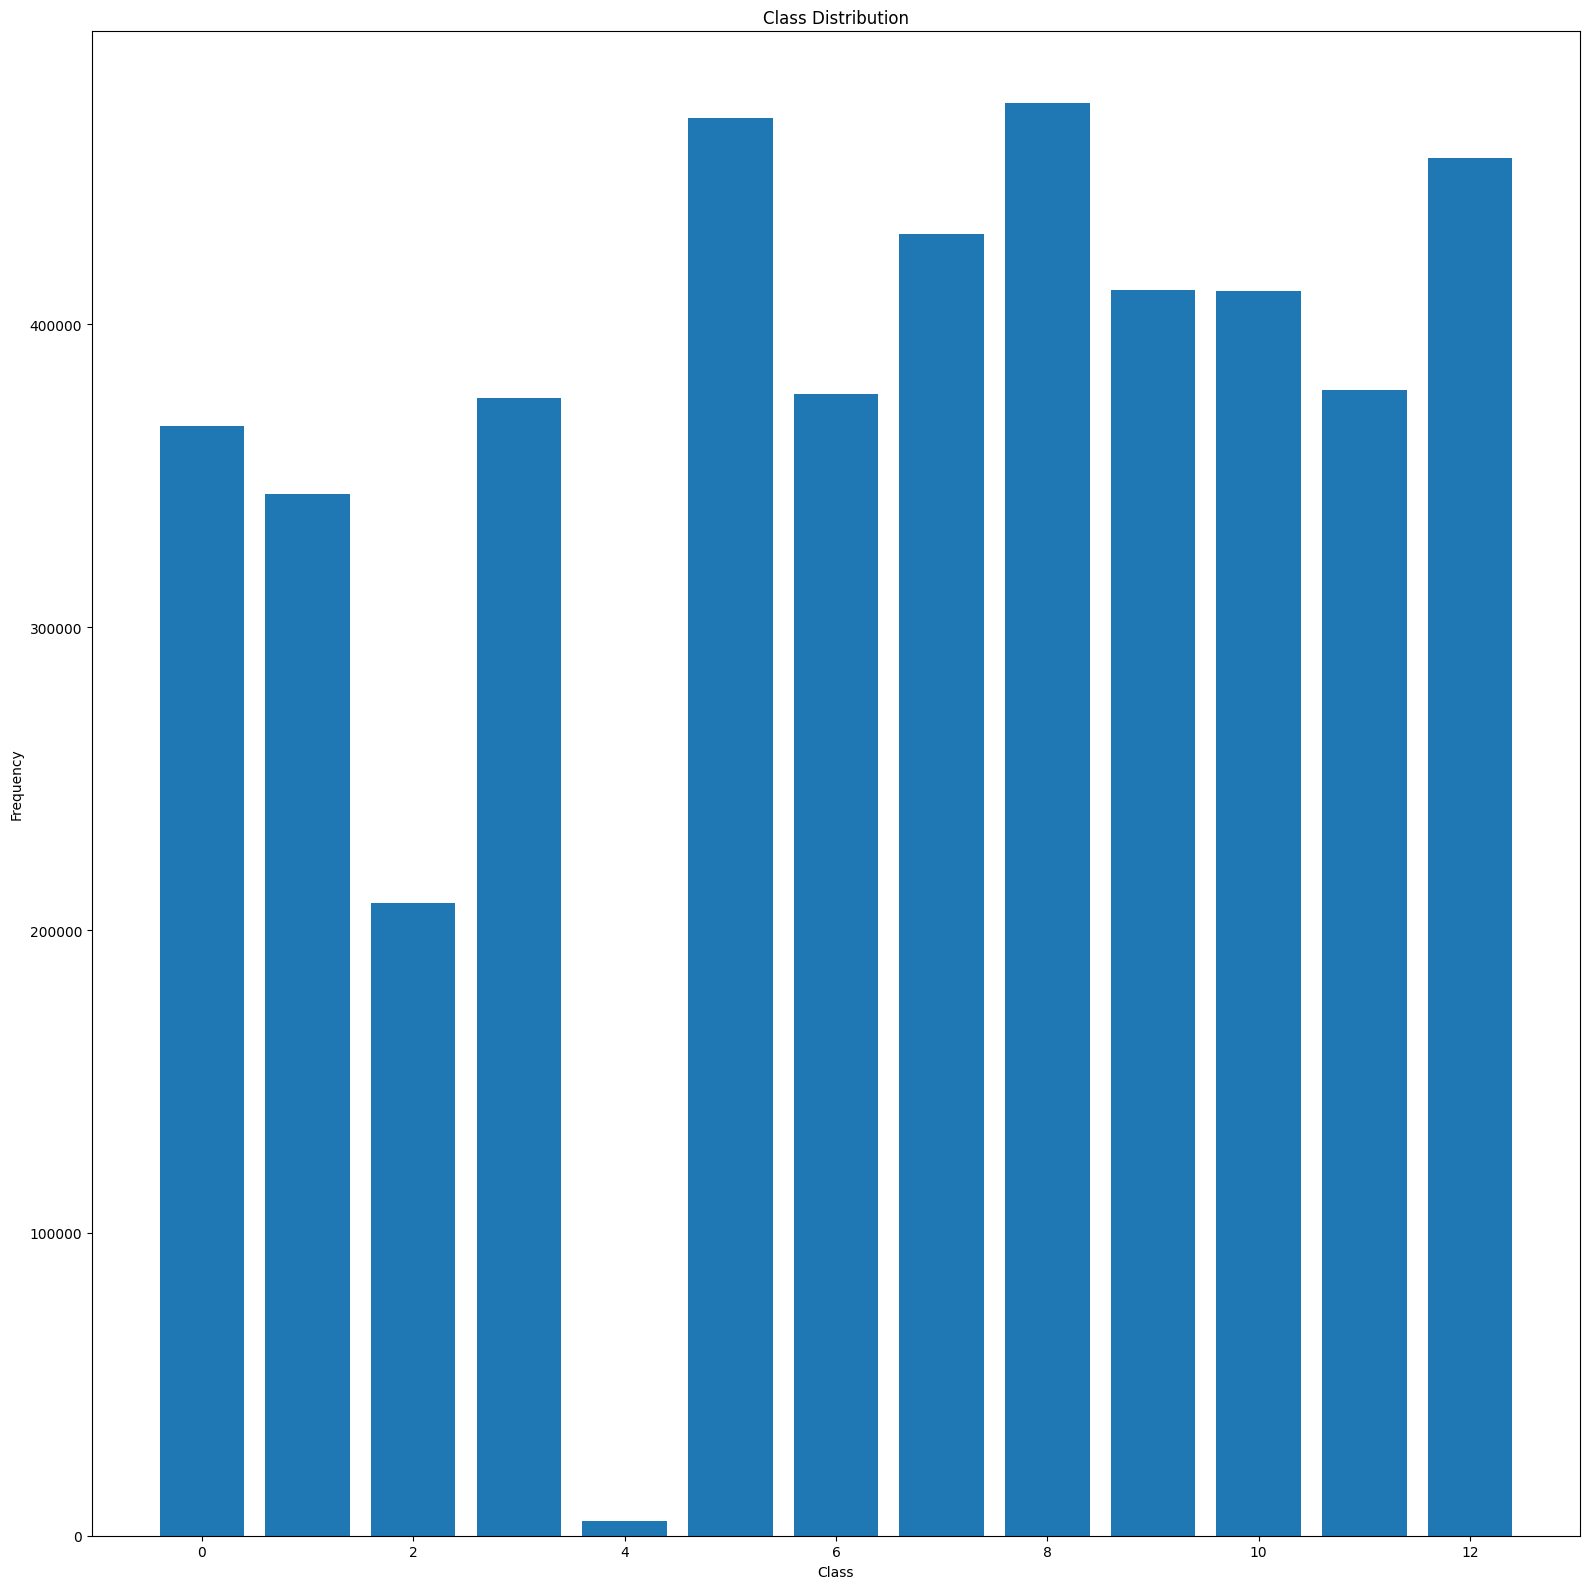

In [19]:
plt.figure(figsize=(16,16))
plt.hist(y_train, bins=np.arange(13 + 1) - 0.5, rwidth=0.8)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

In [20]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 366565,
 1: 343852,
 2: 208896,
 3: 375750,
 4: 4964,
 5: 468243,
 6: 376986,
 7: 429771,
 8: 473124,
 9: 411212,
 10: 410884,
 11: 378230,
 12: 455053}

## CNN

In [21]:
# Reshape X for CNN input (CNN expects 3D input: samples, timesteps, features)
X_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_cnn.shape

(4703530, 95, 1)

In [22]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(13, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss= 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
input_shape = (X_cnn.shape[1], 1)

all_scores = []
for train_index, val_index in kf.split(X_cnn):
    X_train_fold, X_val_fold = X_cnn[train_index], X_cnn[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create a new model instance for each fold
    model = create_model(input_shape)

    # Fit the model
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train_fold, y_train_fold, epochs=25, batch_size=128, validation_data=(X_val_fold, y_val_fold),
          callbacks=[early_stopping])

    # Evaluate the model on the validation set
    score = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    all_scores.append(score)

# Print the mean and standard deviation of the scores
mean_score = np.mean(all_scores, axis=0)
std_score = np.std(all_scores, axis=0)
print(f'Mean Validation Loss: {mean_score[0]:.4f}, Mean Validation Accuracy: {mean_score[1]:.4f}')
print(f'Standard Deviation Loss: {std_score[0]:.4f}, Standard Deviation Accuracy: {std_score[1]:.4f}')

Epoch 1/25
29398/29398 ━━━━━━━━━━━━━━━━━━━━ 287s 10ms/step - accuracy: 0.7187 - loss: 1.0125 - val_accuracy: 0.8164 - val_loss: 0.6643
Epoch 2/25
29398/29398 ━━━━━━━━━━━━━━━━━━━━ 250s 9ms/step - accuracy: 0.7734 - loss: 0.7595 - val_accuracy: 0.8141 - val_loss: 0.6409
Epoch 3/25
29398/29398 ━━━━━━━━━━━━━━━━━━━━ 271s 9ms/step - accuracy: 0.7786 - loss: 0.7337 - val_accuracy: 0.8205 - val_loss: 0.6141
Epoch 4/25
29398/29398 ━━━━━━━━━━━━━━━━━━━━ 248s 8ms/step - accuracy: 0.7799 - loss: 0.7242 - val_accuracy: 0.8092 - val_loss: 0.6066
Epoch 5/25
29398/29398 ━━━━━━━━━━━━━━━━━━━━ 268s 9ms/step - accuracy: 0.7812 - loss: 0.7169 - val_accuracy: 0.8228 - val_loss: 0.6044
Epoch 6/25
29398/29398 ━━━━━━━━━━━━━━━━━━━━ 272s 9ms/step - accuracy: 0.7814 - loss: 0.7136 - val_accuracy: 0.8164 - val_loss: 0.5952
Epoch 7/25
29398/29398 ━━━━━━━━━━━━━━━━━━━━ 262s 9ms/step - accuracy: 0.7819 - loss: 0.7101 - val_accuracy: 0.8226 - val_loss: 0.5951
Epoch 8/25
29398/29398 ━━━━━━━━━━━━━━━━━━━━ 266s 9ms/step - a

In [26]:
X_test_cnn = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))  # Same reshape

y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class predictions

19852/19852 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7459
           1       0.75      0.72      0.74     44658
           2       0.74      0.98      0.85     43715
           3       0.31      0.88      0.46     42422
           4       1.00      0.74      0.85    367217
           5       0.10      0.99      0.18       300
           6       0.73      0.25      0.37     44242
           7       0.40      0.51      0.45      6769
           8       0.57      0.87      0.69      3278
           9       0.26      0.75      0.39     15361
          10       0.36      0.44      0.39     11290
          11       1.00      0.82      0.90     43761
          12       0.16      0.36      0.22      4775

    accuracy                           0.73    635247
   macro avg       0.57      0.71      0.57    635247
weighted avg       0.85      0.73      0.76    635247



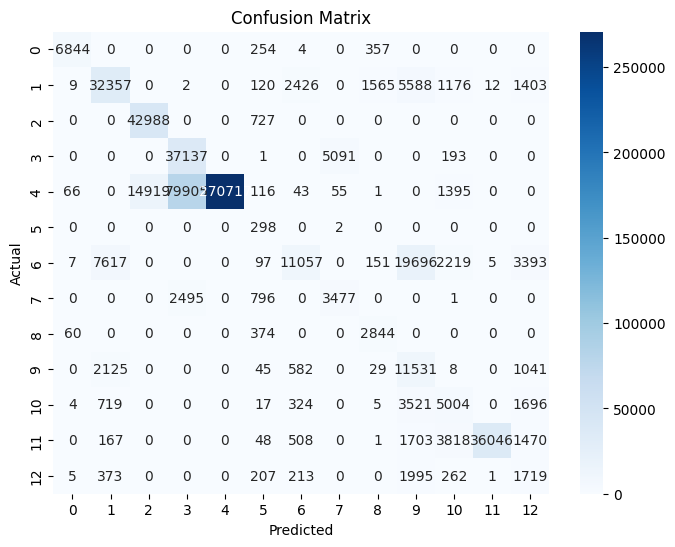

In [27]:
print(classification_report(y_test, y_pred_classes))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()